# Importing Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import os # accessing directory structure
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from itertools import chain
import re
from re import match
import datetime
datetime.datetime.strptime
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [2]:
# Customize matplotlib
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'sans-serif',
        'font.sans-serif': 'Arial',
        'font.size' : 15
    }
)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 



# Loading File

In [3]:
filepath = '../input/gufhtugu-publications-dataset-challenge/GP Orders - 5.csv'
csv_file = filepath

df = pd.read_csv(csv_file,header=0,encoding = 'utf-8')

# Arranging DataFrame

In [4]:
df.rename(columns = {'City':'Address'}, inplace = True) 

df.rename(columns = {'Order Date & Time':'Order Date'}, inplace = True) 

df['Book Name'] = df['Book Name'].apply(str)

df['Address'] = df['Address'].apply(str)

df['Order Status'] = df['Order Status'].apply(str)

df['Hour'] = df['Order Date'].str.extract(r'(\d?\d):')

df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Time'] = df['Order Date'].dt.strftime('%H:%M')

df['Month Year'] = pd.to_datetime(df['Order Date']).dt.to_period('M')

df['Full Date'] = df['Order Date'].dt.date

#If String month and year needed to be extracted from non datetime column of Order Date.
#df['Month Year'] =df['Order Date'].str.extract(r'^(\d+)/') +"/" +df['Order Date'].str.extract(r'(\d{4})')

df['Day'] = pd.to_datetime(df['Order Date']).dt.day_name()
df['Date'] = pd.to_datetime(df['Order Date']).dt.day

#rearrange columns later on.

# Data PreProcessing

Following cleaning/removing Pakistan, Cantt at the beginning/end of string in City Column
and replacing shortforms of cities to full forms and all in lower case results in

In [5]:
#following cleaning/removing Pakistan, Cantt at the beginning/end of string in City Column
#and replacing shortforms of cities to full forms and all in lower case results in
df["Address"] = df["Address"].str.lower()
df["Address"] = df["Address"].apply(str).str.replace(r".?.?[Pp]akistan.?$","")
df["Address"] = df["Address"].apply(str).str.replace(r".?.?\(?[0-9]+ ?.?\)?$","")
df["Address"] = df["Address"].apply(str).str.replace(r".?.?[Cc]antt?.?$","")
df["Address"] = df["Address"].apply(str).str.replace(r"^.?.?[Cc]antt?.?","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?\(?\d+?\)?$","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?sindh$","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?punjab$","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?balochistan$","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?kpk$","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?cantt$","")
df["Address"] = df["Address"].apply(str).str.replace(r"^,? ?cantt","")
df["Address"] = df["Address"].apply(str).str.replace(r"^[a-z]+,? ?distt","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?distt$","")
df["Address"] = df["Address"].apply(str).str.replace(r"^[a-z]+,? ?district","")
df["Address"] = df["Address"].apply(str).str.replace(r",? ?district$","")
df["Address"] = df["Address"].apply(str).str.replace(r"^,?.? ?m[oi]del","")
df["Address"] = df["Address"].apply(str).str.replace(r"^,?.? ?town","")

In [6]:
#old regex
#city_filter_regex=r',? ?[model]?[midel]?[town]?[cantt]?([a-z]+?\.? ?[a-z]+? ?\.?[a-z]+).?\d?[cantt]?\.?$'
city_filter_regex=r'[., ]?([a-z]+?\.? ?[a-z]+? ?\.?[a-z]+).? ?,?$'
#Advanced Regex - implement in next iteration.
#city_filter_regex=r'\b(?!\bcantt| |model|midel|town\b)(\w+? ?\w+? ?\w+)\b$'
df['City'] = df['Address'].str.extract(city_filter_regex)
df['City'] = df['City'].apply(str)

df["City"].replace({"khi": "karachi", "lhr": "lahore", 'lhr':'lahore', 'rwp':'rawalpindi',
                  'isb':'islamabad', ' ':'','karachu':'karachi','queeta':'quetta', 
                  'fsd':'faisalabad'}, inplace=True)

df['Hour'] = df['Hour'].astype('int32')

df['Payment Method'].replace({'Cash on Delivery (COD)':'Cash on delivery'}, inplace=True)

# Order Items Breakdown


To make it easier to calculate frequency and sales. Order items are split from one row per order to individual row per item ordered.


df - one row per one order


df2 - one row per order item. (One order with multiple books will have multiple rows)
                               [one row per one book]

In [7]:
df2 = (df.set_index(['Order Number','Order Status','Order Date','Day','Date','Address','City',
                     'Month Year','Hour','Full Date','Time', 
                     'Payment Method', 'Total items', 'Total weight (grams)'])
    .apply(lambda x: x.str.split('/').explode())
    .reset_index())

**Categorization of Data into bins so Categorical Statistics can be Represented**

In [8]:
categ = [0,5,8,12,16,20,24]
categ_label = ['Late Night 12AM-5AM', 'Early Morning 5AM-8AM','Morning 8AM-12PM','Noon 12PM-4PM' ,'Evening 4PM-8PM',
               'Night 8PM-12AM']
df['Day Part'] = pd.cut(df['Hour'], bins=categ, labels=categ_label, include_lowest=True)

categ = [0,250,500,750,1000,1250,5000]
categ_label = ['0-250 Grams', '250-500 Grams','500-750 Grams','750-1000 Grams' ,'1000-1250 Grams',
               '1250-5000 Grams']
df['Weight Class'] = pd.cut(df['Total weight (grams)'], bins=categ, labels=categ_label, include_lowest=False)

# Visualizing Data

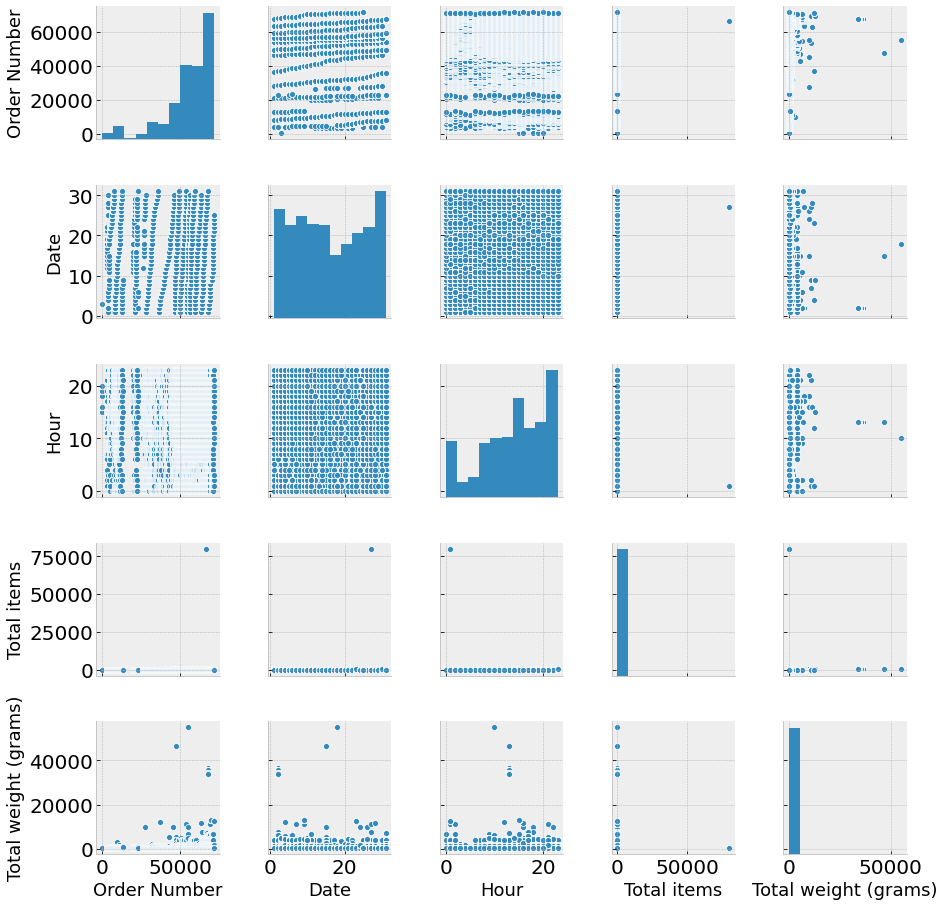

In [9]:
sns.pairplot(df2);
sns.set_style("dark")
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Obj-1 : What is the best-selling book?

 **انٹرنیٹ سے پیسہ کمائیں** is the best selling book.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)


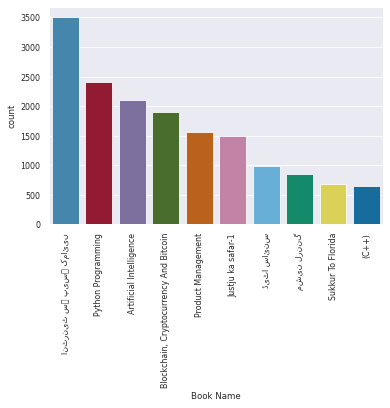

In [10]:
bestsellers = df2.groupby(["Book Name"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False).head(10)
sns.set_style('darkgrid')
sns.set_context("paper", font_scale=0.9) 
plot = sns.barplot(x='Book Name', y='count' ,data=bestsellers)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 90);

                                   Book Name  count
1628                  انٹرنیٹ سے پیسہ کمائیں   3507
1119                      Python Programming   2413
198                  Artificial Intelligence   2105
327   Blockchain, Cryptocurrency And Bitcoin   1906
1113                      Product Management   1553
784                        Justju ka safar-1   1493
1755                              ڈیٹا سائنس    979
1728                              مشین لرننگ    848
1324                       Sukkur To Florida    685
1                                      (C++)    654


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)


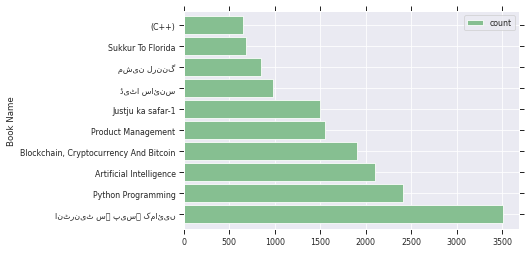

In [11]:
books_trend= df2.groupby(["Book Name"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False).head(10)
print(books_trend)
ax = books_trend.plot(kind= 'barh', x='Book Name',width=0.85,color='#86bf91',zorder=2)
ax.tick_params(axis="both", which="both", 
               bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")


#  Obj - 2: Visualize order status frequency

,Order Status
Completed,17948
Returned,1142
Cancelled,149


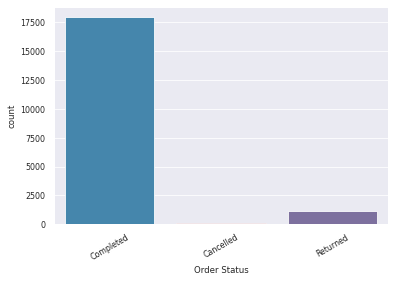

In [12]:
plot = sns.countplot(x='Order Status',data=df)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 30);
order_status_visualize = df['Order Status'].value_counts()
order_status_visualize.to_frame().style.bar()

In [13]:
order_status_visualize = round((df['Order Status'].value_counts()/df['Order Status'].count())*100,1)
order_status_visualize = order_status_visualize.rename('Order Status Frequency (Percentage)')
print('Order Status Frequency Percentage')
print(order_status_visualize)
order_status_visualize.to_frame().style.bar()

Order Status Frequency Percentage
Completed    93.3
Returned      5.9
Cancelled     0.8
Name: Order Status Frequency (Percentage), dtype: float64


,Order Status Frequency (Percentage)
Completed,93.300000
Returned,5.900000
Cancelled,0.800000


# Correlation

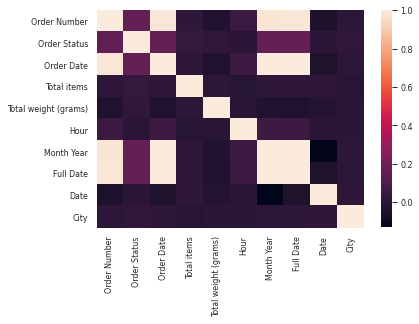

In [14]:
df3 = df.copy(deep = False)
df3['Order Status']=df3['Order Status'].astype('category').cat.codes
df3['City']=df3['City'].astype('category').cat.codes
df3['Month Year']=df3['Month Year'].astype('category').cat.codes
df3['Order Date'] = pd.to_datetime(df3['Order Date'])
df3['Full Date'] = pd.to_datetime(df3['Full Date'])
df3['Order Date'] = pd.to_numeric(df3['Order Date'])
df3['Full Date'] = pd.to_numeric(df3['Full Date'])
sns.heatmap(df3.corr())

# Obj - 3: Find a correlation between date and time with order status

To increase the time window for a correlation, only hour is extracted from time value.

                      Order Status  Total items  Total weight (grams)  \
Order Status              1.000000     0.027613              0.014816   
Total items               0.027613     1.000000              0.001983   
Total weight (grams)      0.014816     0.001983              1.000000   
Hour                     -0.001009    -0.014593             -0.009679   
Full Date                 0.164771     0.008101             -0.034543   

                          Hour  Full Date  
Order Status         -0.001009   0.164771  
Total items          -0.014593   0.008101  
Total weight (grams) -0.009679  -0.034543  
Hour                  1.000000   0.047990  
Full Date             0.047990   1.000000  


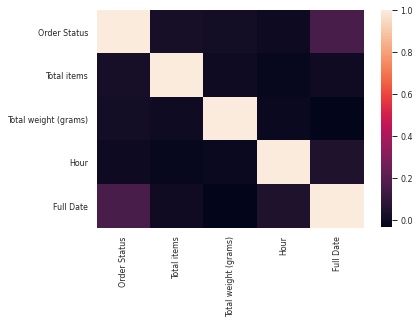

In [15]:
print(df3.drop(['Order Number','Order Date', 'Date', 'City','Month Year'], axis=1).corr())
sns.heatmap(df3.drop(['Order Number', 'Date', 'City','Order Date','Month Year'], axis=1).corr())


Text(0.5, 1.0, 'Full Date and Order Status')

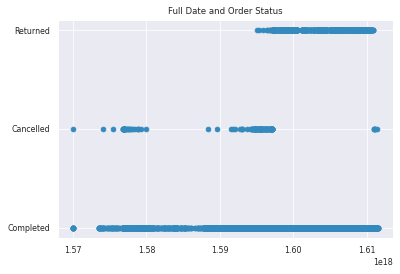

In [16]:
plt.scatter(df3['Full Date'], df['Order Status'])
plt.title('Full Date and Order Status')

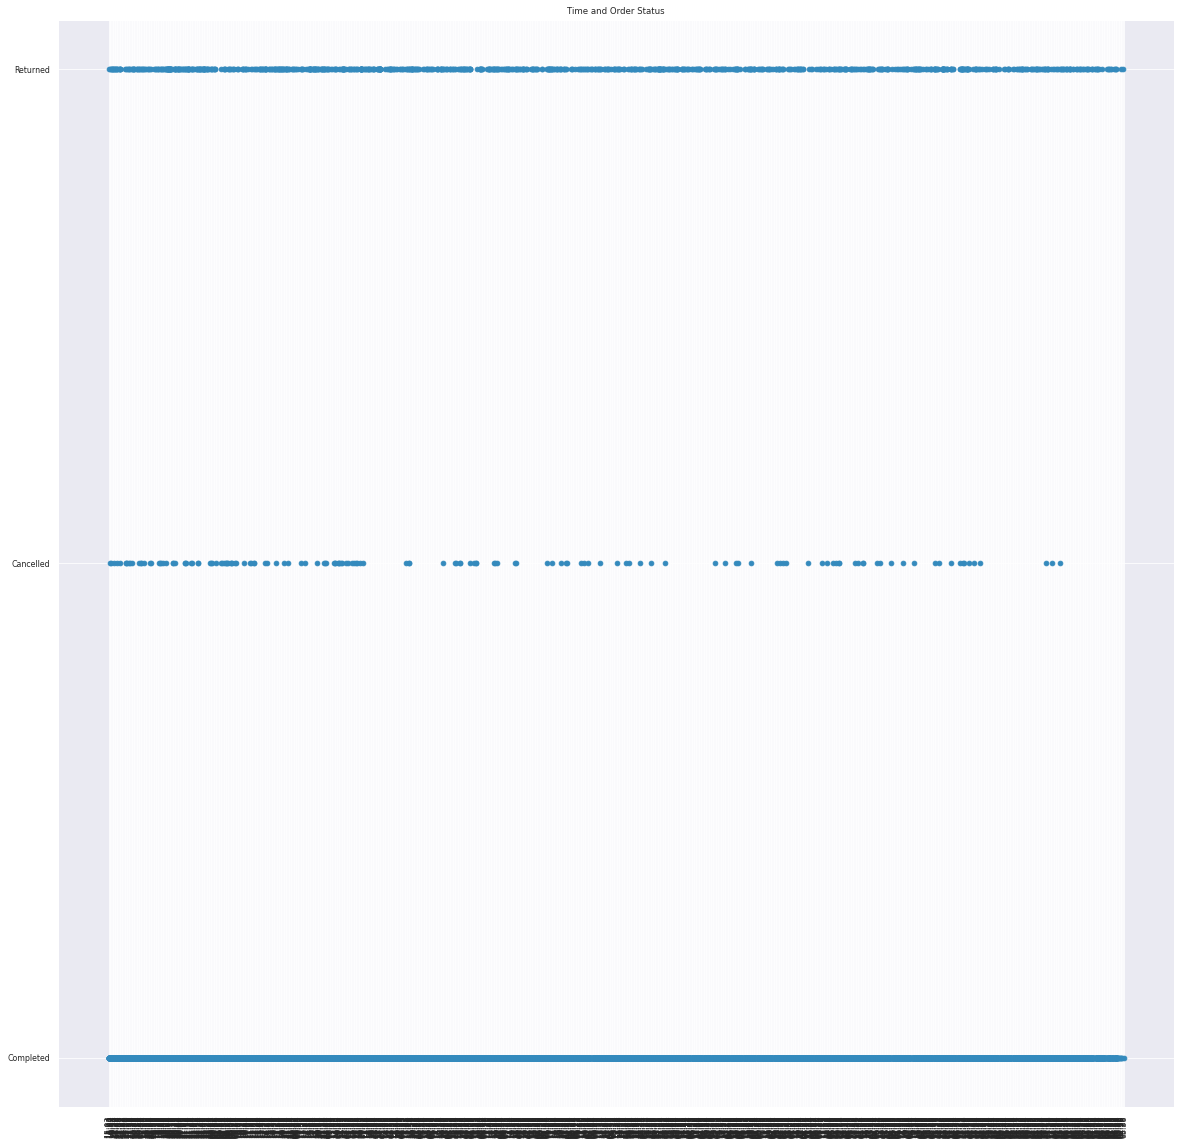

In [17]:
plt.scatter(df3['Time'], df['Order Status'])
plt.gcf().set_size_inches((20, 20))    
plt.title('Time and Order Status')
plt.xticks(rotation='vertical')
plt.show()

Text(0.5, 1.0, 'Time and Order Status')

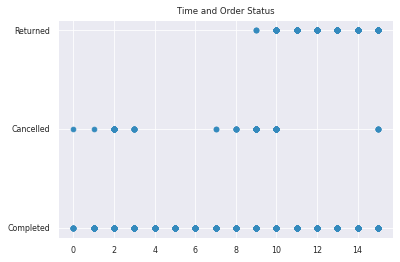

In [18]:
plt.scatter(df3['Month Year'], df['Order Status'])
plt.title('Time and Order Status')

Explore correlation between time ordered and cancelled order?

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

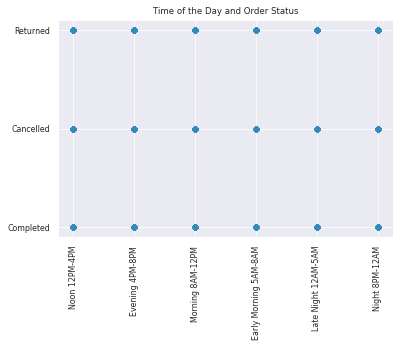

In [19]:
plt.scatter(df3['Day Part'], df['Order Status'])
plt.title('Time of the Day and Order Status')
plt.xticks(rotation=90)

 # Obj : Probabilities


In [20]:
total_orders = len(df.index)
completed = len(df.loc[df['Order Status'] == 'Completed'])
cancelled = len(df.loc[df['Order Status'] == 'Cancelled'])
returned = len(df.loc[df['Order Status'] == 'Returned'])

**Probability of Return**

In [21]:
return_prob = round(returned/total_orders * 100,2)
print('the probability of return is {}%'.format(return_prob))

the probability of return is 5.94%


In [22]:
cancel_prob = round(cancelled/total_orders * 100,2)
print('the probability of cancellation is {}%'.format(cancel_prob))

the probability of cancellation is 0.77%


 # Obj - 4: Find a correlation between city and order status

                      Order Status  Total items  Total weight (grams)  \
Order Status              1.000000     0.027613              0.014816   
Total items               0.027613     1.000000              0.001983   
Total weight (grams)      0.014816     0.001983              1.000000   
City                      0.017090    -0.011277             -0.006454   

                          City  
Order Status          0.017090  
Total items          -0.011277  
Total weight (grams) -0.006454  
City                  1.000000  


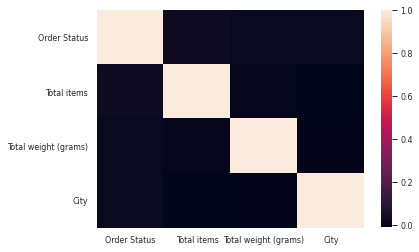

In [23]:
print(df3.drop(['Order Number','Order Date', 'Date', 'Hour', 'Full Date','Month Year'], axis=1).corr())
sns.heatmap(df3.drop(['Order Number', 'Date', 'Order Date','Hour', 'Full Date','Month Year'], axis=1).corr())

Text(0.5, 1.0, 'City and Order Status')

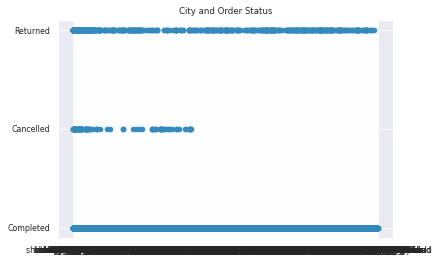

In [24]:
plt.scatter(df['City'], df['Order Status'])
plt.title('City and Order Status')

# Obj - 5:Find any hidden patterns that are counter-intuitive for a layman

**Sales Trend By Time Of Day**

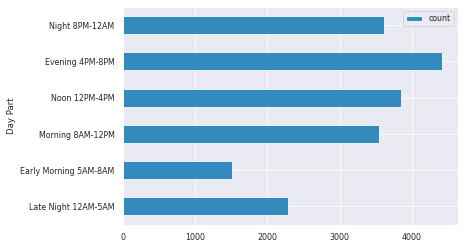

In [25]:
sales_trend_timeOfDay= df.groupby(["Day Part"])["Order Number"].agg(["count"]).reset_index()
sales_trend_timeOfDay.sort_values("Day Part",ascending = True).plot(kind= 'barh', x='Day Part');

**Sales Trend By Month**

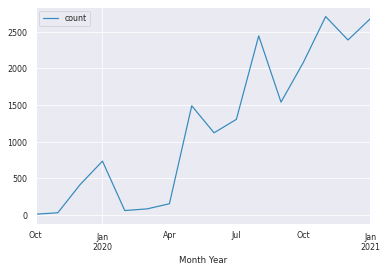

In [26]:
sales_trend= df.groupby(["Month Year"])["Order Number"].agg(["count"]).reset_index()
sales_trend.sort_values("Month Year",ascending = True).plot(kind= 'line', x='Month Year');

**Sales show a growing trend from late 2019 to present (Jan 2021)**

**Most Sales by City**

            City  count
1116     karachi   5706
1342      lahore   4330
962    islamabad   2485
1991  rawalpindi   1295
672   faisalabad    992


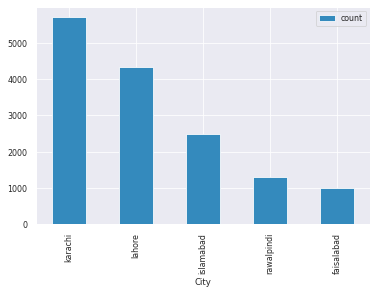

In [27]:
city_most_sales= df2.groupby(["City"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False).head(5)
print(city_most_sales)
city_most_sales.plot(kind= 'bar', x='City');

**Sales By Weekday**

         Day  count    sum
0   Saturday   4270   7683
1     Sunday   3651  87356
2     Friday   2911   5059
3     Monday   2454   4805
4    Tuesday   2043   3328
5  Wednesday   1968   4010
6   Thursday   1942   4191


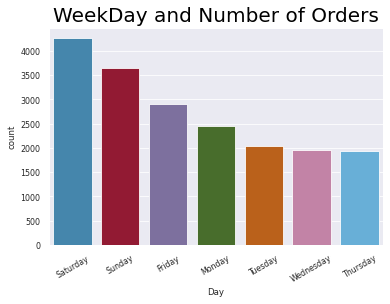

In [28]:
best_weekday_sales= df.groupby(["Day"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False)
best_weekday_sales = best_weekday_sales.set_index('Day')
temp_df = df.groupby(["Day"])["Total items"].agg(["sum"])
best_weekday_sales= best_weekday_sales.join(temp_df).reset_index()
print(best_weekday_sales)
#best_weekday_sales.plot(kind= 'barh', x='Day');
plot = sns.barplot(x='Day', y='count',data=best_weekday_sales)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 30);
plt.title(label="WeekDay and Number of Orders", 
          fontsize=20, 
          color="Black"); 

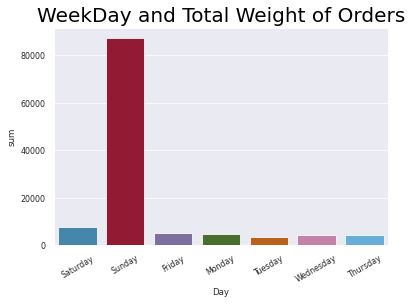

In [29]:
plot = sns.barplot(x='Day', y='sum',data=best_weekday_sales)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 30);
plt.title(label="WeekDay and Total Weight of Orders", 
          fontsize=20, 
          color="Black"); 

**Orders Classified according to weight**

This doesn't include orders where weight was exactly 0.

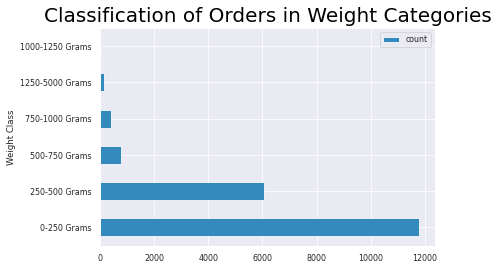

In [30]:
order_weight_distribution = df.groupby(["Weight Class"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False)
order_weight_distribution.plot(kind= 'barh', x='Weight Class');
plt.title(label="Classification of Orders in Weight Categories", 
          fontsize=20, 
          color="Black"); 

**Orders Classified by mode of Payment Selected**

Cash on delivery    17477
EasyPaisa             697
JazzCash              596
BankTransfer          459
Name: Payment Method, dtype: int64


,Payment Method Distribution (Percentage)
Cash on delivery,90.900000
EasyPaisa,3.600000
JazzCash,3.100000
BankTransfer,2.400000


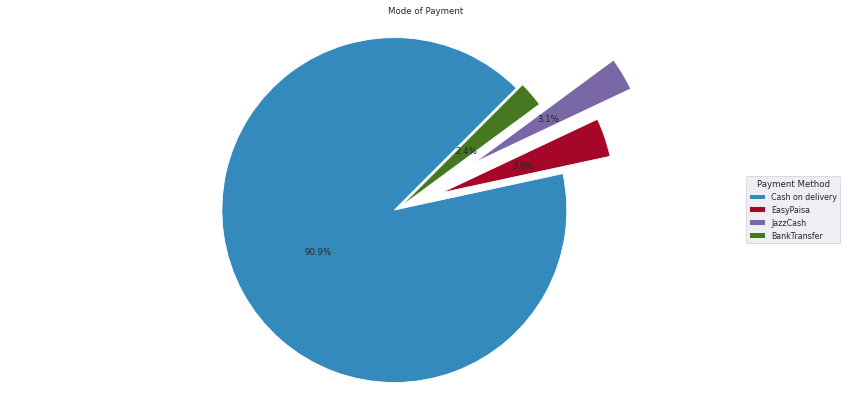

In [31]:
#payment_method_distribution = df.groupby(["Payment Method"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False)
#payment_method_distribution.plot(kind= 'bar', x='Payment Method')

count_paymentmode = df['Payment Method'].value_counts()
explode = (0.05, 0.3, 0.6, 0)
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.pie(count_paymentmode.values, autopct='%1.1f%%', radius=1.2, startangle=45, explode=explode,pctdistance=0.5)
ax1.axis('equal')
plt.title("Mode of Payment")
plt.legend(count_paymentmode.index, title="Payment Method",loc="center right")
plt.show

payment_method_distribution2 = round((df['Payment Method'].value_counts()/df['Payment Method'].count())*100,1)
payment_method_distribution2 = payment_method_distribution2.rename('Payment Method Distribution (Percentage)')
print(df['Payment Method'].value_counts())
payment_method_distribution2.to_frame().style.bar()

**Orders Classified by number of Books in order**

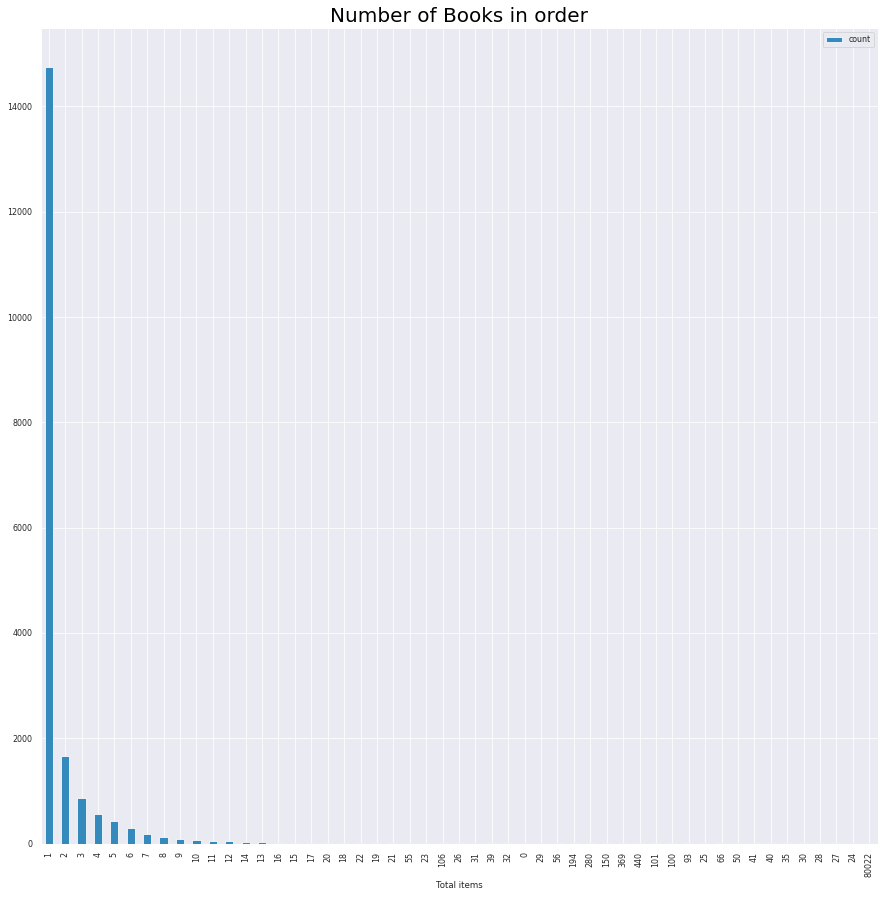

In [32]:
books_quantity_distribution = df.groupby(["Total items"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False)
books_quantity_distribution.plot(kind= 'bar', x='Total items',figsize=(15,15))
plt.title(label='Number of Books in order', 
          fontsize=20, 
          color="Black");


**Strong trend of ordering only one book per order**

# **Orders during Sale Period Jan 1,2021 TO Jan 10, 2021**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


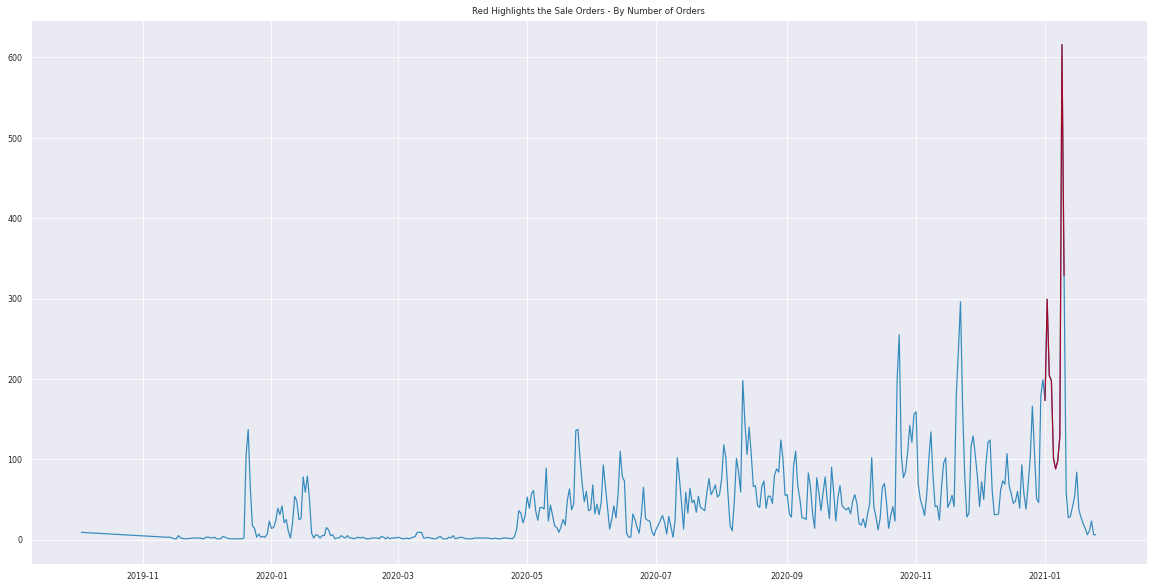

In [33]:
df_sales = df.copy(deep = False)
df_sales.set_index('Order Date')
sales_start = pd.to_datetime('2020/12/31')
sales_end = pd.to_datetime('2021/1/11')

df_sales['salesdates'] = df_sales['Order Date'].dt.date
df_sales.salesdates.value_counts().sort_index().plot()

df_salesdatesonly = df_sales.loc[(df_sales['Full Date']>sales_start) & (df_sales['Full Date']<sales_end) ,:]

df_salesdatesonly['salesdates'] = df_salesdatesonly['Order Date'].dt.date
df_salesdatesonly.salesdates.value_counts().sort_index().plot(figsize=(20,10), 
                                                              title='Red Highlights the Sale Orders - By Number of Orders')


**Let's Zoom in on the timeperiod from 10 days before the sales start upto 10 days after the sale ends**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


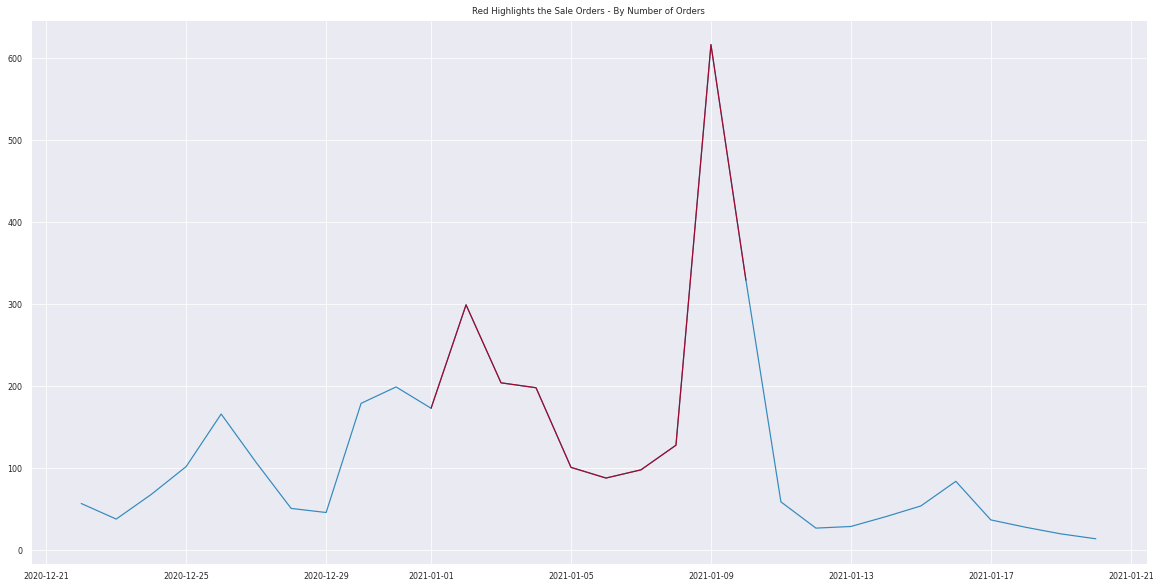

In [34]:
sales_start_10 = pd.to_datetime('2020/12/21')
sales_end_10 = pd.to_datetime('2021/1/21')

dfsalesplusminusten = df_sales.loc[(df_sales['Full Date']>sales_start_10) & (df_sales['Full Date']<sales_end_10) ,:]
dfsalesplusminusten.salesdates.value_counts().sort_index().plot()

df_salesdatesonly = df_sales.loc[(df_sales['Full Date']>sales_start) & (df_sales['Full Date']<sales_end) ,:]

df_salesdatesonly['salesdates'] = df_salesdatesonly['Order Date'].dt.date
df_salesdatesonly.salesdates.value_counts().sort_index().plot(figsize=(20,10), 
                                                              title='Red Highlights the Sale Orders - By Number of Orders')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


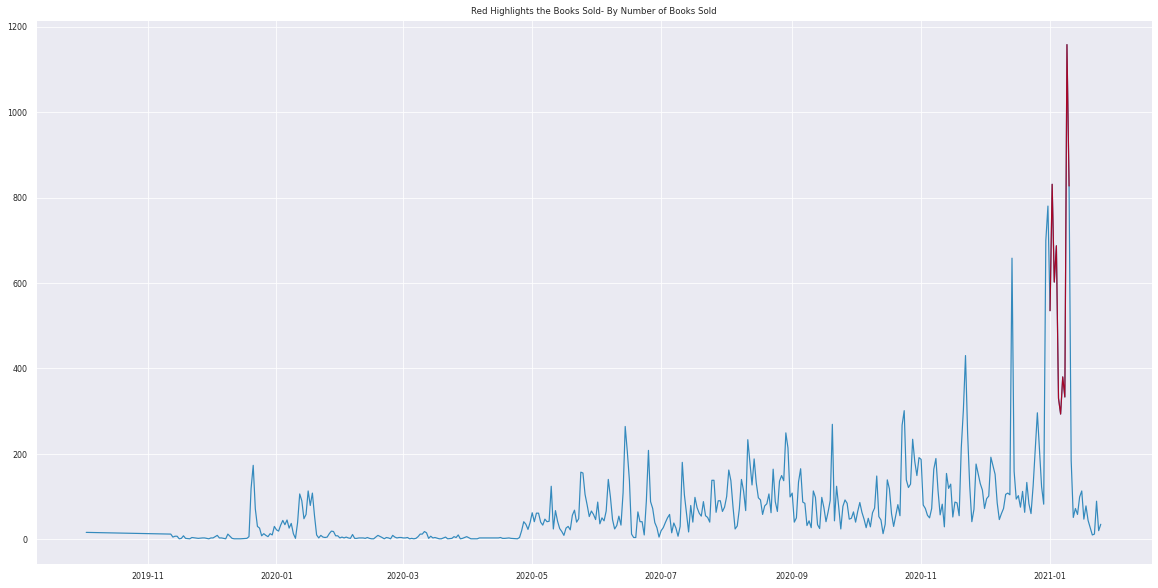

In [35]:
df_sales = df2.copy(deep = False)
df_sales.set_index('Order Date')
sales_start = pd.to_datetime('2020/12/31')
sales_end = pd.to_datetime('2021/1/11')

df_sales['salesdates'] = df_sales['Order Date'].dt.date
df_sales.salesdates.value_counts().sort_index().plot()

df_salesdatesonly = df_sales.loc[(df_sales['Full Date']>sales_start) & (df_sales['Full Date']<sales_end) ,:]

df_salesdatesonly['salesdates'] = df_salesdatesonly['Order Date'].dt.date
df_salesdatesonly.salesdates.value_counts().sort_index().plot(figsize=(20,10), 
                                                              title='Red Highlights the Books Sold- By Number of Books Sold')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


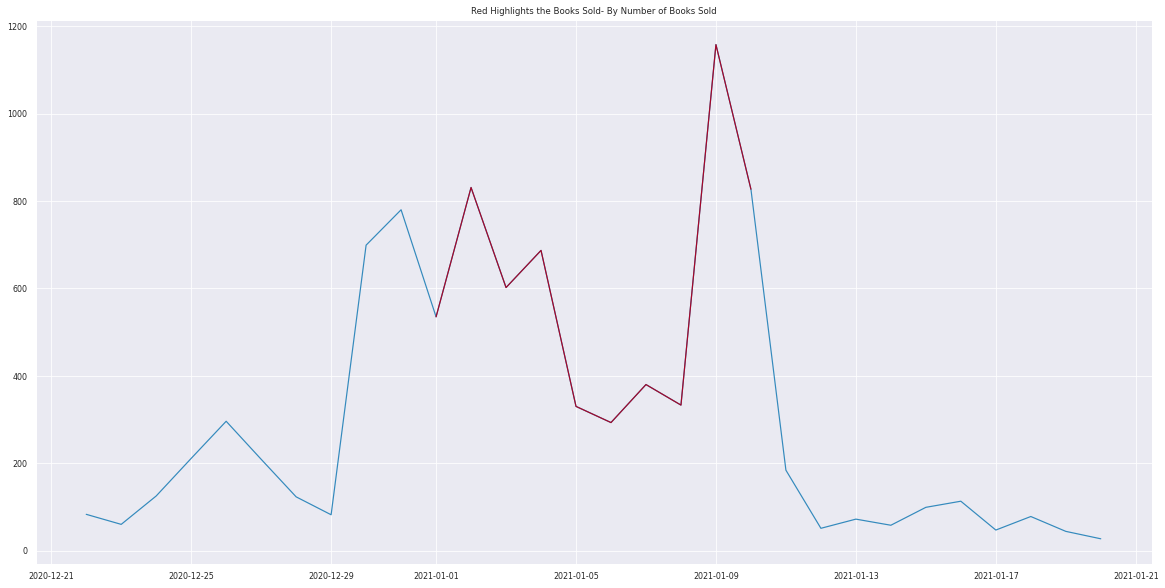

In [36]:
sales_start_10 = pd.to_datetime('2020/12/21')
sales_end_10 = pd.to_datetime('2021/1/21')

dfsalesplusminusten = df_sales.loc[(df_sales['Full Date']>sales_start_10) & (df_sales['Full Date']<sales_end_10) ,:]
dfsalesplusminusten.salesdates.value_counts().sort_index().plot()

df_salesdatesonly = df_sales.loc[(df_sales['Full Date']>sales_start) & (df_sales['Full Date']<sales_end) ,:]

df_salesdatesonly['salesdates'] = df_salesdatesonly['Order Date'].dt.date
df_salesdatesonly.salesdates.value_counts().sort_index().plot(figsize=(20,10), 
                                                              title='Red Highlights the Books Sold- By Number of Books Sold')

In [37]:
df_sales = df2.copy(deep = False)
df_sales.set_index('Order Date')
sales_start = pd.to_datetime('2020/12/31')
sales_end = pd.to_datetime('2021/1/11')
df_sales['salesdates'] = df_sales['Order Date'].dt.date
df_saleperiod = df_sales.loc[(df_sales['Full Date']>sales_start) & (df_sales['Full Date']<sales_end) ,:]


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)


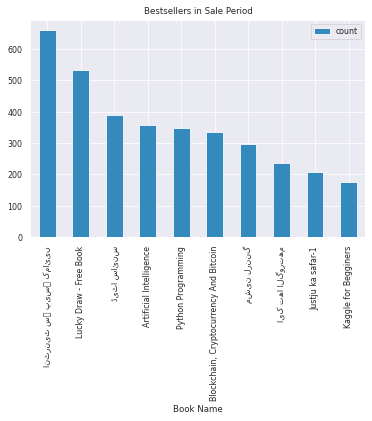

In [38]:
books_trend= df_saleperiod.groupby(["Book Name"])["Order Number"].agg(["count"]).reset_index().sort_values("count",ascending = False).head(10)
books_trend.plot(kind= 'bar', x='Book Name', title='Bestsellers in Sale Period');

In [39]:
order_status_visualize = df_saleperiod['Order Status'].value_counts()
order_status_visualize.to_frame().style.bar()
order_status_visualize = round((df_saleperiod['Order Status'].value_counts()/df_saleperiod['Order Status'].count())*100,1)
order_status_visualize = order_status_visualize.rename('Order Status Frequency (Percentage)')
print('Order Status Frequency Percentage During Sale Period')
order_status_visualize.to_frame().style.bar()


Order Status Frequency Percentage During Sale Period


,Order Status Frequency (Percentage)
Completed,93.300000
Returned,6.700000


# **Interpretting these plots**

# **Out of 33094 books total sold 5594 books were sold in Sale. That is about 17% of all time Sales with zero cancellations. **


Four plots above show the sales period.
First two plots count the number of orders. (one order is counted one even if it is of 100 books)
Last two plots count the number of books sold. (one order is counted as many times as books are in that order)


1. This Sales period recorded the highest number of sales.
2. The Sales picked up at the start of sale period as expected.
3. Sales peaked near the end of period.
4. Peak observed near the end of the period when most of the books were sold out/ not available anymore.
5. Sales dropped after the sale period ends.
6. Sales starts to drop before the end could be attributed to stock run-outs.
7. It should be expected - that it will take some time for sales to return to pre-sales period as people bought in advance


**What the business can do to make the most of sales next time?**

1. Start Marketing well ahead of time. 
2. Let people know that books are limited in stock and will run out.
3. Use analytics to know which books will be most sold and prepare the invertory that way.

**Orders wrt Order Time, No of items and Payment Method**

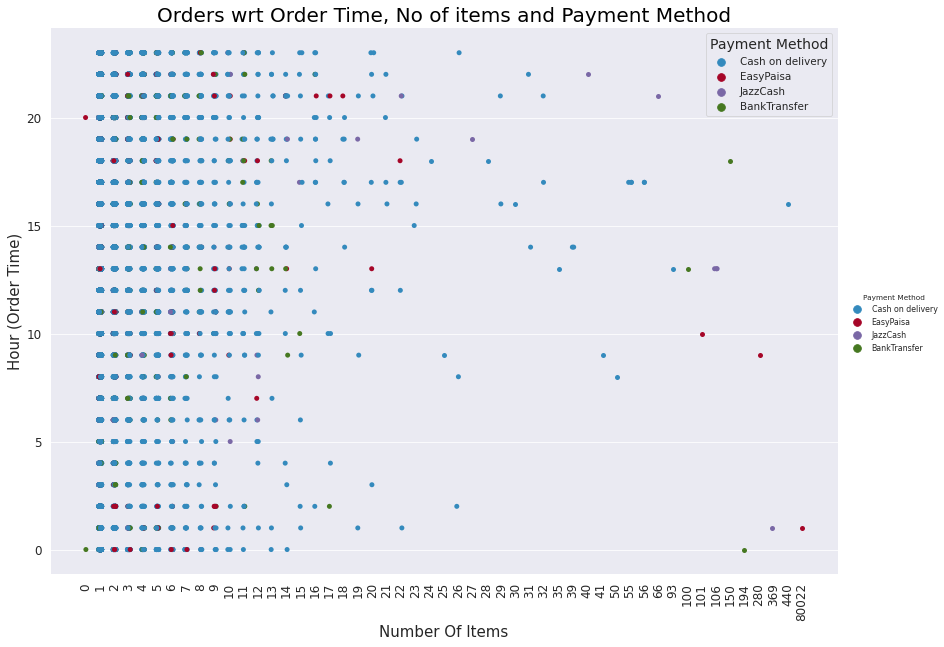

In [40]:
sns.catplot(x="Total items", y="Hour", hue='Payment Method', jitter=True, data=df,height=8.27, aspect=11.7/8.27)
plt.axis('auto');
plt.xticks(rotation=90);
plt.tick_params(axis='both', which='major', labelsize=12);
plt.tick_params(axis='both', which='minor', labelsize=10);
plt.xlabel('Number Of Items', fontsize=15);
plt.ylabel('Hour (Order Time)', fontsize=15);
plt.legend(title="Payment Method",loc="best",title_fontsize=14, fontsize='large');
plt.title(label="Orders wrt Order Time, No of items and Payment Method",
          fontsize=20, 
          color="Black");

**Interesting Point Noticeable in the Chart above**

Orders containing high number of items, the ordered time is NEVER in the range of 2AM to 8AM.

# Obj - 6 Can we predict number of orders, or book names in advance?

# This Work is in progress.

I'd like to ask you for suggestions to improve my implementation. Or if you have any feedback for me.

Please do so in comments - It will be of great help 
 
Thank you.

# Improvements I have planned for second version.

1. Graphs/Plots (Titles on graphs, Color coded visualizations)
2. Clean up data in city column more.
3. Urdu Text not showing up in Graphs
4. Correlation between type of book and time ordered?
5. Try this approach -> Type of books ordered by City. Classified into city size, population, literacy, avg.income etc.
        Use this for ML model to predict orders.

# Humble Recommendations for Gufthugu

1. Build a dataset containing Book names, Authors name, # of Pages, Category and Publisher is included.
                Category as in either it is fiction or non fiction 
                Sub Category as in it is self-help/ autobiography/ technical coursebook etc. 
                Publisher - categories (guftugu's own publication/under licence etc.
    This will help in further analysis of buying patterns.
    We can understand whether people buy spiritual books more in the morning or in the evening.
    Similarly if people in big cities buy different kind of books than in smaller cities. 
    
    How will this be helpful?
    One use can be for Marketing demographics/psychographics - In future you can use this analysis for
    effectively creating ad campaigns for right target audiences.
    

2. In your order page, create separate entry fields for information.
    
    As you can see in Ciy Billing Column, one entry is used in multiple ways so if you create entry
    parameters such as a drop down list to select City and and then another drop down list for Sub-Area
    within City then you'll much cleaner data collection. Moreover Book buying trends can be classified
    not only at city level but also at town/area level.
  